In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import scipy.stats as stats
from scipy.special import expit
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, 
                             mean_absolute_percentage_error, root_mean_squared_error)
from sklearn.inspection import permutation_importance
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Normalization

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\delivery.csv")
df = df.drop(columns=df[['Order_ID','Weather', 'Traffic_Level','Time_of_Day', 'Vehicle_Type']])
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,12,1.0,43
1,16.42,20,2.0,84
2,9.52,28,1.0,59
3,7.44,5,1.0,37
4,19.03,16,5.0,68


In [3]:
x = df.drop(columns=['Delivery_Time_min']).values
y = df['Delivery_Time_min'].values

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [5]:
normalizer = Normalization(axis=-1)
normalizer.adapt(x_train)
x_train_adapt = normalizer(x_train)
x_test_adapt = normalizer(x_test)

In [6]:
def build_model_wide_deep_hb(hp):
    input_layer = tf.keras.layers.Input(shape=(x_train_adapt.shape[1],))
    wide = tf.keras.layers.Dense(1, activation='linear')(input_layer)
    deep = input_layer
    for i in range(hp.Int('num_layers', 1, 3)):
        deep = tf.keras.layers.Dense(units=hp.Int(f'units_{i}', min_value = 16, max_value = 128, step=8),
                                     activation = hp.Choice('activation',['relu','tanh']),
                                     kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'l2_{i}', min_value=1e-5, max_value=1e-3, sampling='log'))
        )(deep)
        deep = tf.keras.layers.BatchNormalization()(deep)
        deep = tf.keras.layers.Dropout(
            rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
        )(deep)

    combined = tf.keras.layers.concatenate([wide, deep])
    output = tf.keras.layers.Dense(1, activation='linear')(combined)

    model = tf.keras.Model(inputs = input_layer, outputs = output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr',[0.01, 0.001])),
                  loss='mse',
                  metrics=['mae'])
    return model

In [ ]:
hyperband_tune = kt.Hyperband(
    build_model_wide_deep_hb,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperband_wdr',
    project_name='cancer_hb'
    )

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
    )

In [9]:
hyperband_tune.search(x_train_adapt, y_train,
                      validation_split=0.2, batch_size=18,
                      verbose=True)

Trial 30 Complete [00h 00m 27s]
val_loss: 3081.012939453125

Best val_loss So Far: 194.557373046875
Total elapsed time: 00h 10m 14s


In [10]:
top_hps = hyperband_tune.get_best_hyperparameters(num_trials=1)[0]

In [16]:
def build_model_wide_deep_bs(hp):
    input_layer = tf.keras.layers.Input(shape=(x_train_adapt.shape[1],))
    wide = tf.keras.layers.Dense(1, activation='linear')(input_layer)
    deep = input_layer
    for i in range(top_hps.get('num_layers')):
        deep = tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', 
                         min_value=min(16, top_hps.get(f'units_{i}') - 16),
                         max_value=max(128, top_hps.get(f'units_{i}') + 16),
                         step=8),
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh']),
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'l2_{i}',
                                                             min_value=min(1e-5,top_hps.get(f'l2_{i}')- 1e-5),
                                                             max_value=max(1e-3, top_hps.get(f'l2_{1}')+1e-5),
                                                             sampling='log'))
        )(deep)
        deep = tf.keras.layers.BatchNormalization()(deep)
        deep = tf.keras.layers.Dropout(
            rate=hp.Float(f'dropout_rate_{i}', 
                          min_value=min(0.1, top_hps.get(f'dropout_rate_{i}') - 0.1),
                          max_value=max(0.5, top_hps.get(f'dropout_rate_{i}') + 0.1),
                          step=0.1))(deep)

    combined = tf.keras.layers.concatenate([wide, deep])
    output = tf.keras.layers.Dense(1, activation='linear')(combined)

    model = tf.keras.Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', 
                                                                   [top_hps.get('lr') * 0.1,
                                                                    top_hps.get('lr'),
                                                                    top_hps.get('lr') * 10])),
        loss='mse',
        metrics=['mae']
    )
    return model

In [17]:
bayesian_tune = kt.BayesianOptimization(
    build_model_wide_deep_bs,
    objective='val_mae',
    max_trials=2,
    directory='bayes_wdr',
    project_name='cancer_bs'
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [18]:
bayesian_tune.search(x_train_adapt, y_train,
                     validation_split=0.2, epochs=10,
                     batch_size=18, verbose=True,
                     )

Trial 2 Complete [00h 00m 22s]
val_mae: 8.630410194396973

Best val_mae So Far: 8.450289726257324
Total elapsed time: 00h 00m 44s


In [19]:
best_hps = bayesian_tune.get_best_hyperparameters(num_trials=1)[0]

In [20]:
best_model = bayesian_tune.hypermodel.build(best_hps)

In [21]:
history = best_model.fit(x_train_adapt, y_train,
                         validation_split=0.2,
                         epochs=10,
                         batch_size=16,
                         verbose=True)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 1627.3053 - mae: 33.7692 - val_loss: 236.9339 - val_mae: 11.3439
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 209.2447 - mae: 10.7653 - val_loss: 202.5246 - val_mae: 9.2642
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 191.4061 - mae: 10.0103 - val_loss: 197.9466 - val_mae: 10.0647
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 168.1111 - mae: 9.3962 - val_loss: 206.0873 - val_mae: 9.5795
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 189.4002 - mae: 9.9529 - val_loss: 291.6852 - val_mae: 11.8100
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 185.6832 - mae: 9.4477 - val_loss: 246.8338 - val_mae: 10.1909
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 155.9051 - mae: 9.1628 - val_loss: 221.3369 - val_mae: 9.7215
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 154.2922 - mae: 8.8844 - val_loss: 225.1332 - val_mae: 9.2799
Epoch 9/10
39/39 ━━━━━━━

In [22]:
y_pred = best_model.predict(x_test_adapt)
proba = expit(y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


In [23]:
print(proba)
print(y_pred)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [24]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

n = len(y_test)
p = x_test.shape[1]
r2_adj = 1 - ((1-r2) * (n - 1) / (n - p - 1))

print(mse)
print(mae)
print(rmse)
print(mape)
print(r2)
print(r2_adj)

123.20648441134261
7.572169156418633
11.09984163902092
0.1421234468466748
0.755474328994751
0.7516133973472997


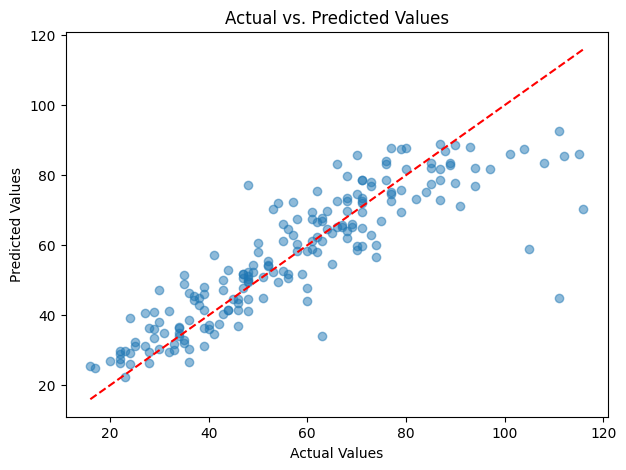

In [25]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

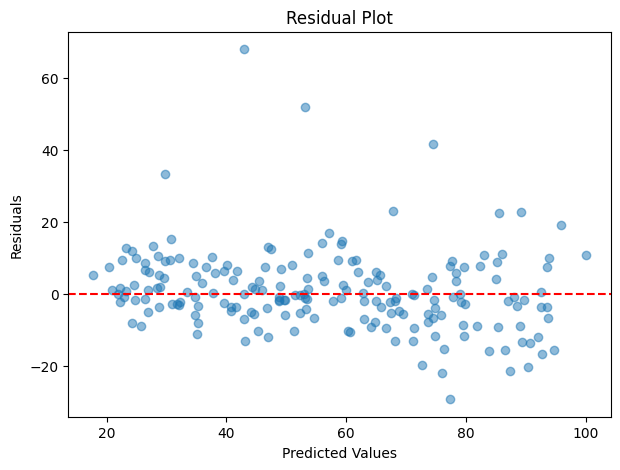

In [21]:
y_predict = np.array(y_pred).flatten() 
residuals = y_test - y_predict

plt.figure(figsize=(7, 5))
plt.scatter(y_predict, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

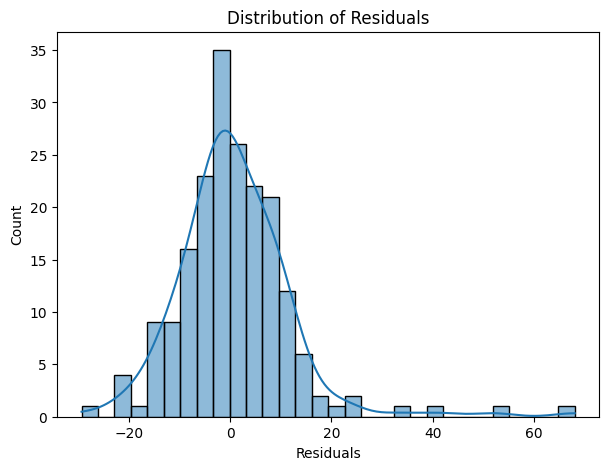

In [22]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

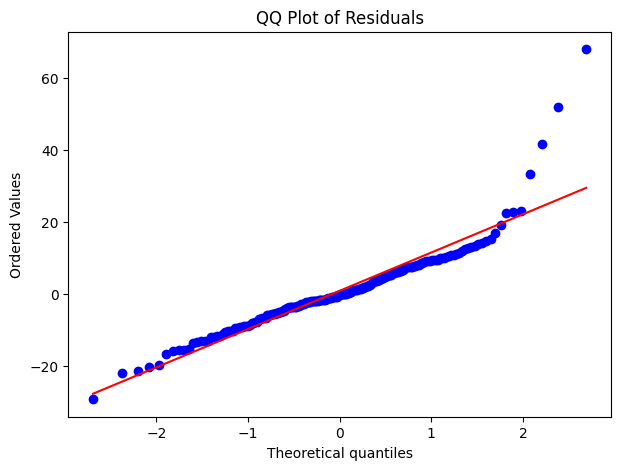

In [23]:
plt.figure(figsize=(7, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

In [24]:
print("\nModel Evaluation:")
results = best_model.evaluate(x_test_adapt, y_test, verbose=0)
metrics = dict(zip(best_model.metrics_names, results))
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Model Evaluation:
loss: 127.2101
compile_metrics: 7.6579


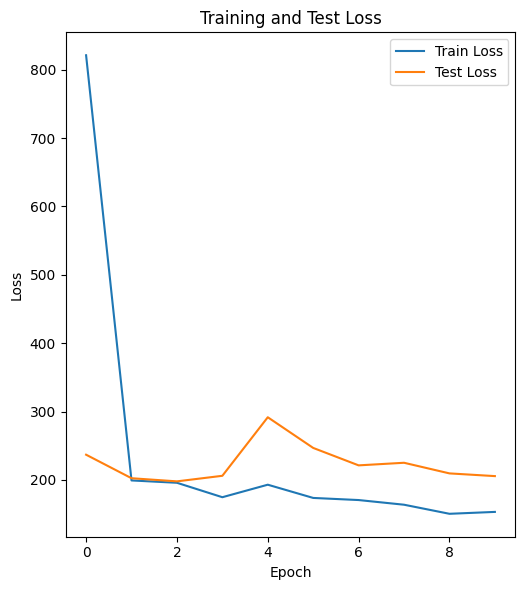

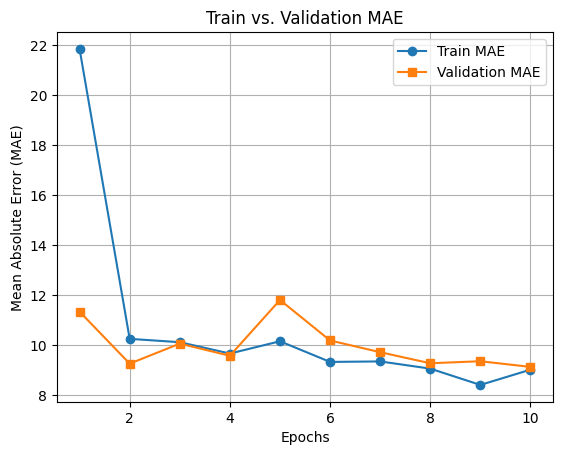

In [26]:
train_loss = history.history['loss']
test_loss = history.history['val_loss'] 
train_mae = history.history['mae']  
val_mae = history.history['val_mae'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_mae, label='Train MAE', marker='o')
plt.plot(epochs, val_mae, label='Validation MAE', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Train vs. Validation MAE")
plt.legend()
plt.grid()
plt.show()

Feature 0: 0.4063687026500702
Feature 1: 0.16309787333011627
Feature 2: 0.025433098897337914


C:\Users\Robyi\AppData\Local\Temp\ipykernel_11380\4198205115.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")


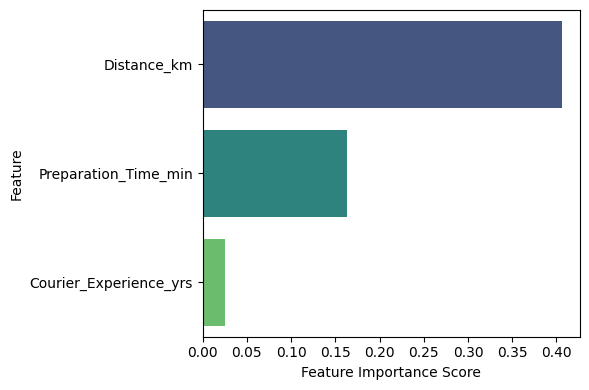

In [27]:
for layer in best_model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()[0]
        break 
else:
    raise ValueError("Tidak ada Dense layer dengan bobot di model!")

feature_importance = np.mean(np.abs(weights), axis=1)
column = df.drop(columns=['Delivery_Time_min'])
feature_names = column.columns

for i, importance in enumerate(feature_importance):
    print(f"Feature {i}: {importance}")

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [28]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          4 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        128 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 33)        │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         34 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 500 (1.96 KB)

 Trainable params: 166 (664.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 334 (1.31 KB)

In [29]:
explainer = shap.Explainer(best_model, x_train)

if hasattr(x_test_adapt, 'numpy'):
    x_test_adapt = x_test_adapt.numpy()
shap_values = explainer(x_test_adapt)

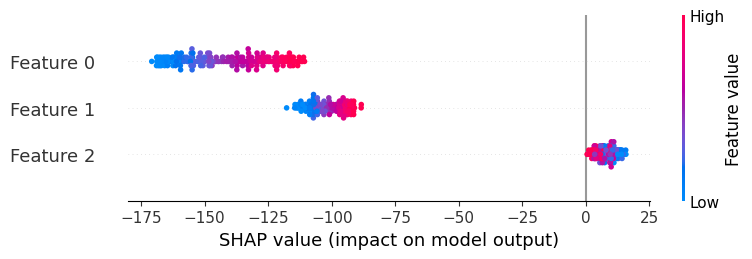

In [30]:
shap.summary_plot(shap_values.values, x_test_adapt)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\deliverypredict.csv")
prediksi.head()

In [ ]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = expit(y_prediksi)
print(y_prediksi)
print(probabilitas_prediksi)